Notes
- I think I am getting the box-plots wrong
- For each density bin, I am getting the distribution of the normalized volume
    - This is **not** the same as the distribution of the volume-weighted age, which I think is what I really want
   - Here I think I'm just getting some perspective on the skewness of the distribution within each density bin...?
- I'm now doing it correctly in the first plot

In [1]:
import xarray as xr
from xhistogram.xarray import histogram
import gfdl_utils as gu
import gsw
import glob
import xesmf as xe
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from dask.diagnostics import ProgressBar
import cftime

In [73]:
pathDict = {'pp':('/archive/Raphael.Dussin/'+
                  'FMS2019.01.03_devgfdl_20210706/'+
                  'CM4_piControl_c192_OM4p125_v6_alt1/'+
                  'gfdl.ncrc4-intel18-prod-openmp/pp'),
           'ppname':'ocean_annual_z_d2',
           'out':'av',
           'local':'annual_10yr',
           'time':'*'}

if pathDict['out']=='ts':
    variables = ['agessc','volcello','so','thetao']
    ds = xr.Dataset()
    for variable in variables:
        pathDict['add']=variable
        tmp = gu.core.open_frompp(**pathDict)
        ds = xr.merge([ds,tmp])
else:
    pathDict['add']='ann'
    ds = gu.core.open_frompp(**pathDict)
    
ds = ds.chunk({'time':1})

In [74]:
# Calculate density
ds['sigma2'] = gsw.sigma2(ds['so'],ds['thetao'])
ds['sigma2'].name = 'sigma2'

In [75]:
agemax = ds['agessc'].max(dim=['xh','yh','z_l'])
bins_sigma2 = np.arange(32,38.05,0.05)
bins_agessc = np.arange(0,1.01,0.01)
hs = histogram(ds['sigma2'],
               ds['agessc']/agemax,
               bins=[bins_sigma2,bins_agessc],
               dim=['xh','yh','z_l'],
               weights=ds['volcello'],
               block_size=len(ds['time']))

In [76]:
with ProgressBar():
    hs = hs.load()

[########################################] | 100% Completed |  1min 28.8s


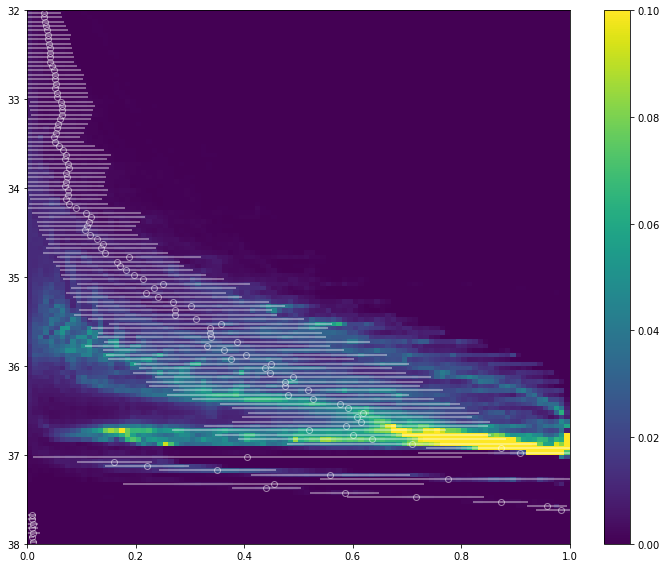

In [115]:
fig,ax = plt.subplots(figsize=(10,8))

tmp = hs.isel(time=-1)
tmp = tmp/tmp.sum('sigma2_bin')

agearray = tmp['agessc_bin']*xr.ones_like(tmp)
mean = agearray.weighted(tmp).mean('agessc_bin')
std = agearray.weighted(tmp).std('agessc_bin')

im = ax.pcolormesh(tmp['agessc_bin'],tmp['sigma2_bin'],tmp,shading='auto',vmax=0.1)
ax.errorbar(mean,mean['sigma2_bin'],xerr=std,linestyle='',ecolor='w',alpha=0.5,marker='o',markerfacecolor='None',markeredgecolor='w')
ax.invert_yaxis()
ax.set_xlim([0,1])
plt.colorbar(im,ax=ax)
fig.tight_layout()

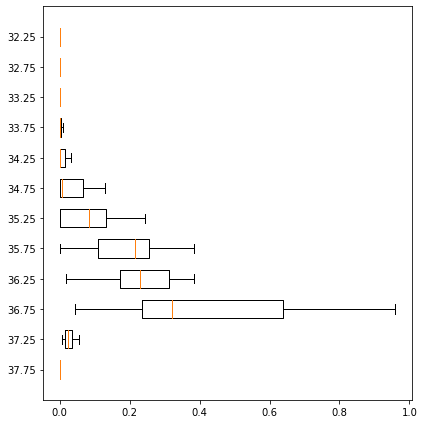

In [107]:
fig,ax = plt.subplots(figsize=(6,6))

tmp = hs.coarsen(sigma2_bin=10,boundary='exact').sum()
tmp = tmp/tmp.sum('sigma2_bin')
# tmp = tmp.fillna(0)

s = np.round(tmp['sigma2_bin'],2)
dels = np.append(np.diff(s)[0],np.diff(s))
delsnow = dels*0.6

ax.boxplot(tmp.isel(time=-1).transpose(),vert=False,sym='',positions=s,widths=delsnow)

ax.invert_yaxis()
# ax.set_xlim([0,1])
# plt.colorbar(im,ax=ax)
fig.tight_layout()

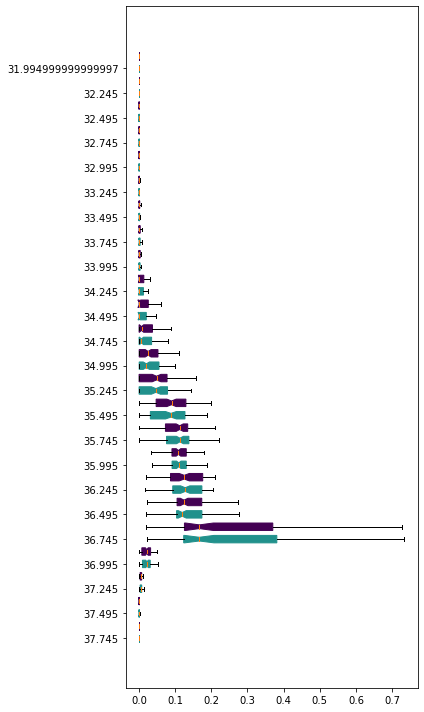

In [53]:
fig,ax = plt.subplots(figsize=(6,10))

tmp = hs.coarsen(sigma2_bin=5,boundary='exact').sum()
tmp = tmp/tmp.sum('sigma2_bin')

nt = len(tmp['time'])

s = np.round(tmp['sigma2_bin'],2)
dels = np.append(np.diff(s)[0],np.diff(s))
delsnow = dels*0.6/nt

colors = plt.cm.viridis(np.arange(nt)/nt)

for time in range(nt):
    snow = s+(dels*(time-nt/2)/nt)
    ax.boxplot(tmp.isel(time=time).transpose(),
               notch=True,
               vert=False,
               sym='',
               patch_artist=True,
               positions=snow,
               widths=delsnow,
               boxprops=dict(facecolor=colors[time,:], color=colors[time,:]))

ax.set_yticks(s)
ax.invert_yaxis()
ax.autoscale(enable=True, axis='y', tight=True)
# ax.set_xlim([0,1])
# plt.colorbar(im,ax=ax)
fig.tight_layout()

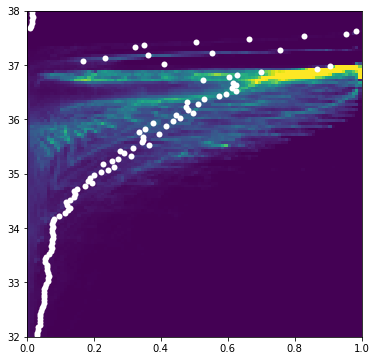

In [72]:
tmp = hs.isel(time=0)
tmp = tmp/tmp.sum('sigma2_bin')
mean = (tmp*tmp['agessc_bin']).sum('agessc_bin')/tmp.sum('agessc_bin')
fig,ax = plt.subplots(figsize=(6,6))
ax.pcolormesh(tmp['agessc_bin'],tmp['sigma2_bin'],tmp,shading='auto',vmax=0.1)
ax.plot(mean,mean['sigma2_bin'],linestyle='',marker='o',markerfacecolor='w',markeredgecolor='None')


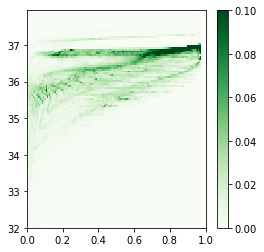

In [109]:
fig,ax = plt.subplots(figsize=(4,4))
time = 200
tmp = hs.isel(time=-1)
tmp = tmp/tmp.sum('sigma2_bin')

im = ax.pcolormesh(tmp['agessc_bin']/time,tmp['sigma2_bin'],tmp,shading='auto',vmax=0.1,cmap='Greens')
ax.set_xlim([0,1])
plt.colorbar(im,ax=ax)

(0.0, 1.0)

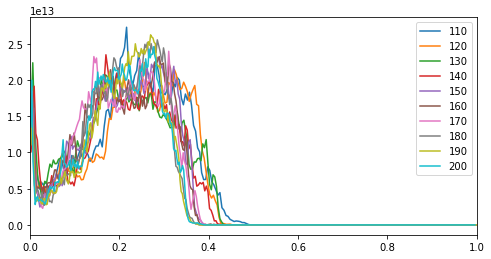

In [117]:
fig,ax = plt.subplots(figsize=(8,4))
sigma2 = 37.1
tmp = hs.sel(sigma2_bin=sigma2,method='nearest')
# tmp = tmp/tmp.sum('sigma2_bin')
times = np.arange(110,210,10)
for i,time in enumerate(times):
    tmpnow = tmp.isel(time=i)
    im = ax.plot(tmpnow['agessc_bin']/time,tmpnow,label=str(time))
ax.legend()
ax.set_xlim([0,1])

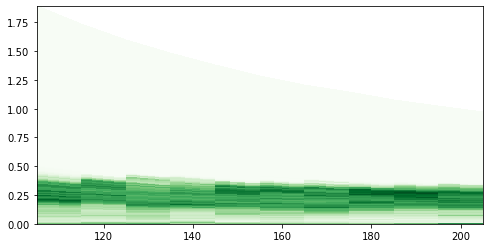

In [127]:
fig,ax = plt.subplots(figsize=(8,4))
sigma2 = 37.1
tmp = hs.sel(sigma2_bin=sigma2,method='nearest')
times = np.arange(110,210,10)
xtimes = xr.DataArray(times,dims='time',coords={'time':times})
im = ax.pcolormesh(xtimes,tmp['agessc_bin']/xtimes,tmp.transpose(),cmap='Greens')
# ax.legend()
# ax.set_xlim([0,1])

In [120]:
tmp['time']/xtimes

<xarray.DataArray (time: 0)>
array([], dtype=object)
Coordinates:
  * time        (time) object 
    sigma2_bin  float64 37.12

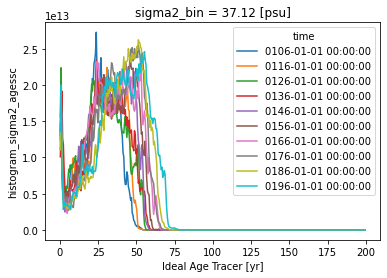

In [107]:
hs.sel(sigma2_bin=37.1,method='nearest').plot(hue='time')

In [66]:
hs_norm = hs/hs.sum('sigma2_bin')

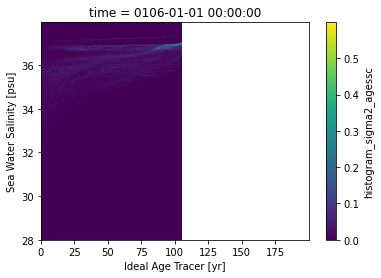

In [67]:
hs_norm.isel(time=0).plot()

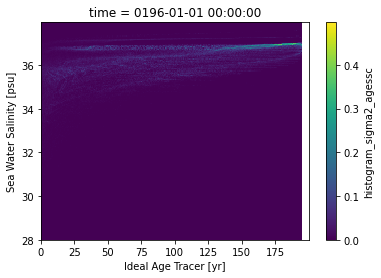

In [68]:
hs_norm.isel(time=-1).plot()

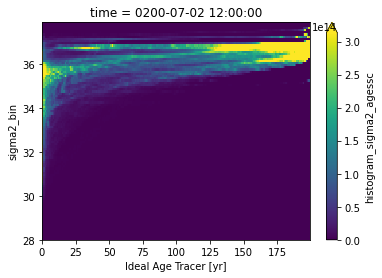

In [102]:
hs.isel(time=-1).plot(robust=True)